In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
from math import radians, degrees
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

from sklearn.preprocessing import scale
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import haversine_distances, euclidean_distances

# 1. Reading the data

## 1.1. Education data build

In [2]:
data_dir = '../data'
education = pd.read_csv(os.path.join(data_dir, 'Education_ForModelling.csv'), index_col=0)
education.shape

(2660, 82)

In [3]:
#Function to display at most 1000 rows and at most 1000 columns
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [4]:
# Change df to geodataframe
education['geometry'] = education['geometry'].apply(wkt.loads)
education = gpd.GeoDataFrame(education, geometry='geometry')

In [5]:
display_all(education.head())

,SCH_ID,SCH_NAME,PSGC_PROV,PSGC_MUNI,PSGC_BRGY,LAT,LONG,address_type,geometry,SCH_CAT_CES,SCH_CAT_ES,SCH_CAT_JHS,SCH_CAT_MD,SCH_CAT_PES,SCH_CAT_PJHS,SCH_CAT_PS,SCH_CAT_PSHS,SCH_CAT_SHS,SCH_CAT_SUC,CES_SCH_PROV,ES_SCH_PROV,JHS_SCH_PROV,MD_SCH_PROV,PES_SCH_PROV,PJHS_SCH_PROV,PS_SCH_PROV,PSHS_SCH_PROV,SHS_SCH_PROV,SUC_SCH_PROV,CES_SCH_MUNI,ES_SCH_MUNI,JHS_SCH_MUNI,MD_SCH_MUNI,PES_SCH_MUNI,PJHS_SCH_MUNI,PS_SCH_MUNI,PSHS_SCH_MUNI,SHS_SCH_MUNI,SUC_SCH_MUNI,CES_SCH_BRGY,ES_SCH_BRGY,JHS_SCH_BRGY,MD_SCH_BRGY,PES_SCH_BRGY,PJHS_SCH_BRGY,PS_SCH_BRGY,PSHS_SCH_BRGY,SHS_SCH_BRGY,SUC_SCH_BRGY,BRGY_SCHOOLS,brgy_area,schools_over_brgy_area,MUNI_SCHOOLS,muni_area,schools_over_muni_area,PROV_SCHOOLS,prov_area,schools_over_prov_area,Pop2010,Pop2015,HH_pop,num_hh0,num_hh0_mal,num_hh0_fem,Total_Pop,Male_Pop,Female_Pop,Total_under10,Total_10to20,Total_21to30,Total_31to60,Total_over60,Female_under10,Female_10to20,Female_21to30,Female_31to60,Female_over60,Male_under10,Male_10to20,Male_21to30,Male_31to60,Male_over60
0,133049,Abong-Abong ES,PH150700000,PH150704000,PH150704001,6.507703,121.910937,given,POINT (121.91094 6.50770),0,1,0,0,0,0,0,0,0,0,16.0,171.0,16.0,1.0,6.0,0.0,14.0,6.0,10.0,1.0,2.0,16.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,4.590691,0.435664,20,88.732750,0.225396,241,1156.417926,0.208402,846.0,965.0,965.0,176.0,155.0,21.0,965.0,473.0,492.0,297.0,245.0,152.0,222.0,49.0,144.0,134.0,85.0,104.0,25.0,153.0,111.0,67.0,118.0,24.0
1,215015,Akbar ES,PH150700000,PH150708000,PH150708008,6.664125,122.195725,given,POINT (122.19572 6.66413),0,1,0,0,0,0,0,0,0,0,16.0,171.0,16.0,1.0,6.0,0.0,14.0,6.0,10.0,1.0,0.0,5.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1.797243,1.112815,7,31.433729,0.222691,241,1156.417926,0.208402,642.0,1093.0,1093.0,175.0,135.0,40.0,1093.0,520.0,573.0,300.0,303.0,134.0,308.0,48.0,134.0,153.0,72.0,185.0,29.0,166.0,150.0,62.0,123.0,19.0
2,133154,Amaloy ES,PH150700000,PH150711000,PH150711001,6.443614,122.126717,given,POINT (122.12672 6.44361),0,1,0,0,0,0,0,0,0,0,16.0,171.0,16.0,1.0,6.0,0.0,14.0,6.0,10.0,1.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3.478142,0.287510,13,71.247126,0.182463,241,1156.417926,0.208402,980.0,1129.0,1129.0,191.0,187.0,4.0,1129.0,586.0,543.0,329.0,284.0,154.0,318.0,44.0,136.0,143.0,91.0,153.0,20.0,193.0,141.0,63.0,165.0,24.0
3,133023,Atong-Atong ES,PH150700000,PH150703000,PH150703001,6.660000,121.899633,given,POINT (121.89963 6.66000),0,1,0,0,0,0,0,0,0,0,16.0,171.0,16.0,1.0,6.0,0.0,14.0,6.0,10.0,1.0,1.0,18.0,2.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,5.649323,0.354025,24,152.681422,0.157190,241,1156.417926,0.208402,1155.0,2368.0,2368.0,419.0,367.0,52.0,2368.0,1173.0,1195.0,594.0,621.0,377.0,661.0,115.0,297.0,295.0,196.0,342.0,65.0,297.0,326.0,181.0,319.0,50.0
4,133081,Babag ES,PH150700000,PH150713000,PH150713001,6.342007,121.954045,given,POINT (121.95404 6.34201),0,1,0,0,0,0,0,0,0,0,16.0,171.0,16.0,1.0,6.0,0.0,14.0,6.0,10.0,1.0,1.0,11.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2.570479,0.389033,16,28.023131,0.570957,241,1156.417926,0.208402,1799.0,2179.0,2179.0,313.0,301.0,12.0,2179.0,1083.0,1096.0,569.0,768.0,320.0,469.0,53.0,280.0,392.0,155.0,239.0,30.0,289.0,376.0,165.0,230.0,23.0


In [6]:
education.describe()

,SCH_ID,LAT,LONG,SCH_CAT_CES,SCH_CAT_ES,SCH_CAT_JHS,SCH_CAT_MD,SCH_CAT_PES,SCH_CAT_PJHS,SCH_CAT_PS,...,Female_under10,Female_10to20,Female_21to30,Female_31to60,Female_over60,Male_under10,Male_10to20,Male_21to30,Male_31to60,Male_over60
count,2660.000000,2660.000000,2660.000000,2660.000000,2660.000000,2660.000000,2660.000000,2660.000000,2660.000000,2660.000000,...,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000
mean,199274.220677,6.885773,122.835085,0.066165,0.481955,0.059023,0.014662,0.039850,0.021805,0.242105,...,387.896318,385.636056,240.171815,372.898434,44.444350,396.347017,383.295387,222.926788,373.874312,47.710961
std,109672.983887,1.089614,5.708151,0.248618,0.499768,0.235711,0.120217,0.195643,0.146072,0.428438,...,534.492732,588.247020,352.305785,522.785604,67.482978,544.514111,583.895162,331.203827,518.722139,70.474669
min,100804.000000,0.000000,-96.683250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19.000000,7.000000,10.000000,28.000000,0.000000,10.000000,13.000000,9.000000,27.000000,0.000000
25%,133733.750000,6.053499,121.135925,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,138.000000,129.000000,80.000000,123.000000,10.000000,139.000000,128.000000,72.000000,125.000000,12.000000
50%,134477.500000,7.011516,124.158333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,240.000000,213.000000,136.000000,213.000000,22.000000,238.000000,212.000000,123.000000,217.000000,24.000000
75%,217062.250000,7.785911,124.325811,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,429.000000,381.000000,246.000000,379.500000,48.000000,442.000000,389.500000,230.500000,377.000000,53.000000
max,800161.000000,33.034414,124.958000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,5068.000000,5688.000000,3286.000000,4652.000000,522.000000,5203.000000,5573.000000,3239.000000,4726.000000,568.000000


In [7]:
# Keep only one record for each brgy and needed features only
brgy_info = education[['PSGC_BRGY',
        'PSGC_MUNI',
        'PSGC_PROV',
        'CES_SCH_BRGY',
        'ES_SCH_BRGY',
        'JHS_SCH_BRGY',
        'MD_SCH_BRGY',
        'PES_SCH_BRGY',
        'PJHS_SCH_BRGY',
        'PS_SCH_BRGY',
        'PSHS_SCH_BRGY',
        'SHS_SCH_BRGY',
        'SUC_SCH_BRGY',
        'BRGY_SCHOOLS']].drop_duplicates(subset='PSGC_BRGY', keep='first')

brgy_info.head()

,PSGC_BRGY,PSGC_MUNI,PSGC_PROV,CES_SCH_BRGY,ES_SCH_BRGY,JHS_SCH_BRGY,MD_SCH_BRGY,PES_SCH_BRGY,PJHS_SCH_BRGY,PS_SCH_BRGY,PSHS_SCH_BRGY,SHS_SCH_BRGY,SUC_SCH_BRGY,BRGY_SCHOOLS
0,PH150704001,PH150704000,PH150700000,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,PH150708008,PH150708000,PH150700000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,PH150711001,PH150711000,PH150700000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,PH150703001,PH150703000,PH150700000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,PH150713001,PH150713000,PH150700000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [8]:
# Combine similar features, 
# i.e., elementary (central ES, ES, primary ES, primary), JHS (JHS, primary JHS), SHS (SHS, primary SHS) schools
brgy_info['num_ES'] = brgy_info['CES_SCH_BRGY'] + brgy_info['ES_SCH_BRGY'] + brgy_info['PES_SCH_BRGY'] + brgy_info['PS_SCH_BRGY']
brgy_info['num_JHS'] = brgy_info['JHS_SCH_BRGY'] + brgy_info['PJHS_SCH_BRGY']
brgy_info['num_SHS'] = brgy_info['PSHS_SCH_BRGY'] + brgy_info['SHS_SCH_BRGY']

# Drop original columns
brgy_info.drop(columns=['CES_SCH_BRGY', 'ES_SCH_BRGY', 'PES_SCH_BRGY', 'PS_SCH_BRGY',
                       'JHS_SCH_BRGY', 'PJHS_SCH_BRGY',
                       'PSHS_SCH_BRGY', 'SHS_SCH_BRGY'],
              inplace=True)

In [9]:
# Rename columns
brgy_info.rename(columns={'Bgy_Code': 'PSGC_BRGY', 'SUC_SCH_BRGY': 'num_SUC', 'MD_SCH_BRGY': 'num_MD'}, inplace=True)
brgy_info.head()

,PSGC_BRGY,PSGC_MUNI,PSGC_PROV,num_MD,num_SUC,BRGY_SCHOOLS,num_ES,num_JHS,num_SHS
0,PH150704001,PH150704000,PH150700000,0.0,0.0,2,2.0,0.0,0.0
1,PH150708008,PH150708000,PH150700000,0.0,0.0,2,1.0,1.0,0.0
2,PH150711001,PH150711000,PH150700000,0.0,0.0,1,1.0,0.0,0.0
3,PH150703001,PH150703000,PH150700000,0.0,0.0,2,1.0,1.0,0.0
4,PH150713001,PH150713000,PH150700000,0.0,0.0,1,1.0,0.0,0.0


## 1.2 Administrative boundaries

<AxesSubplot:>

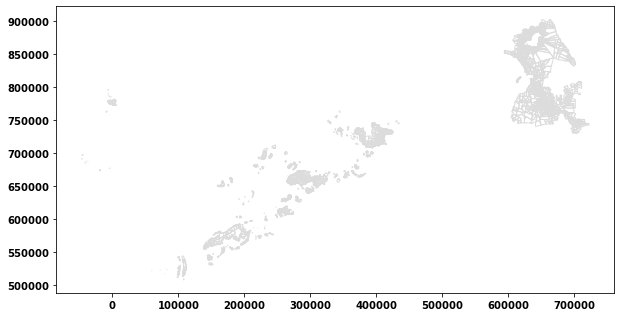

In [10]:
# Read barangay-level admin boundaries from shp file
brgy_dir = '../data/Administrative Boundaries - BARMM Barangays ao 20190206 (PSA 2016)'
brgy_file = 'AdministrativeBoundariesBARMMBarangays20190206PSA2016.shp'
brgy_bounds = gpd.read_file(os.path.join(brgy_dir, brgy_file))

# Visualize bounds
brgy_bounds['geometry'].plot(figsize=(10,10), color='none', edgecolor='gainsboro', zorder=3)

In [11]:
# Add the centroid of each city / municipality
brgy_bounds['centroid'] = brgy_bounds['geometry'].centroid

# Change coordinate reference system to 4326 (lat/long)
brgy_bounds['geometry'] = brgy_bounds['geometry'].to_crs(epsg=4326)
brgy_bounds['centroid'] = brgy_bounds['centroid'].to_crs(epsg=4326)

brgy_bounds['longitude'] = brgy_bounds['centroid'].x
brgy_bounds['latitude'] = brgy_bounds['centroid'].y

display_all(brgy_bounds.head())

,Reg_Code,Reg_Name,Pro_Code,Pro_Name,Mun_Code,Mun_Name,Bgy_Code,Bgy_Name,geometry,centroid,longitude,latitude
0,PH150000000,AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM),PH157000000,TAWI-TAWI,PH157001000,PANGLIMA SUGALA (BALIMBING),PH157001001,Balimbing Proper,"MULTIPOLYGON (((119.95374 5.07851, 119.95384 5...",POINT (119.96552 5.09753),119.965518,5.097532
1,PH150000000,AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM),PH157000000,TAWI-TAWI,PH157001000,PANGLIMA SUGALA (BALIMBING),PH157001002,Batu-batu (Pob.),"POLYGON ((119.88709 5.06919, 119.88709 5.06920...",POINT (119.88302 5.09129),119.883020,5.091289
2,PH150000000,AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM),PH157000000,TAWI-TAWI,PH157001000,PANGLIMA SUGALA (BALIMBING),PH157001003,Buan,"MULTIPOLYGON (((120.06363 5.16131, 120.06365 5...",POINT (120.00070 5.15760),120.000703,5.157595
3,PH150000000,AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM),PH157000000,TAWI-TAWI,PH157001000,PANGLIMA SUGALA (BALIMBING),PH157001004,Dungon,"POLYGON ((120.13585 5.19601, 120.13584 5.19603...",POINT (120.12350 5.21772),120.123501,5.217723
4,PH150000000,AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM),PH157000000,TAWI-TAWI,PH157001000,PANGLIMA SUGALA (BALIMBING),PH157001005,Luuk Buntal,"MULTIPOLYGON (((119.98776 4.98564, 119.98774 4...",POINT (120.00454 4.98161),120.004538,4.981608


In [12]:
# Rename columns
brgy_bounds.rename(columns={'Bgy_Code': 'PSGC_BRGY'}, inplace=True)

# Keep only desired features
brgy_coords = brgy_bounds[['PSGC_BRGY', 'geometry', 'centroid', 'longitude', 'latitude']]
brgy_coords.head()

,PSGC_BRGY,geometry,centroid,longitude,latitude
0,PH157001001,"MULTIPOLYGON (((119.95374 5.07851, 119.95384 5...",POINT (119.96552 5.09753),119.965518,5.097532
1,PH157001002,"POLYGON ((119.88709 5.06919, 119.88709 5.06920...",POINT (119.88302 5.09129),119.883020,5.091289
2,PH157001003,"MULTIPOLYGON (((120.06363 5.16131, 120.06365 5...",POINT (120.00070 5.15760),120.000703,5.157595
3,PH157001004,"POLYGON ((120.13585 5.19601, 120.13584 5.19603...",POINT (120.12350 5.21772),120.123501,5.217723
4,PH157001005,"MULTIPOLYGON (((119.98776 4.98564, 119.98774 4...",POINT (120.00454 4.98161),120.004538,4.981608


## 1.3 Population

In [13]:
# Read barangay-level population
pop_dir = '../data/Tabular - Social'
pop_file = 'Population 2010, 2015 ARMM,BCT.csv'
pop = pd.read_csv(os.path.join(pop_dir, pop_file))
pop.head()

,REGI,PSGC_REGI,PROV,PSGC_PROV,MuniCities,PSGC_CITY/MUNI,BrgyName,PSGC_BRGY,BCT,Pop2010,...,80_abv_mal,num_hh0_fem.1,bel_20_hh0_fem,20-29_hh0_fem,30-39_hh0_fem,40-49_hh0_fem,50-59_hh0_fem,60-69_hh0_fem,70-79_hh0_fem,80_abv_fem
0,Autonomous Region In Muslim Mindanao,PH150000000,Basilan,PH150700000,City Of Lamitan,PH150702000,Arco,PH150702001,1,800,...,3.0,23.0,0.0,1.0,3.0,0.0,8.0,6.0,2.0,3.0
1,Autonomous Region In Muslim Mindanao,PH150000000,Basilan,PH150700000,City Of Lamitan,PH150702000,Ba-as,PH150702002,1,1266,...,3.0,72.0,0.0,9.0,13.0,16.0,13.0,14.0,7.0,0.0
2,Autonomous Region In Muslim Mindanao,PH150000000,Basilan,PH150700000,City Of Lamitan,PH150702000,Baimbing,PH150702004,1,451,...,0.0,25.0,0.0,4.0,1.0,3.0,4.0,8.0,4.0,1.0
3,Autonomous Region In Muslim Mindanao,PH150000000,Basilan,PH150700000,City Of Lamitan,PH150702000,Balagtasan,PH150702005,1,2597,...,6.0,76.0,1.0,2.0,10.0,18.0,24.0,7.0,13.0,1.0
4,Autonomous Region In Muslim Mindanao,PH150000000,Basilan,PH150700000,City Of Lamitan,PH150702000,Balas,PH150702006,1,2809,...,2.0,166.0,2.0,26.0,39.0,28.0,32.0,28.0,7.0,4.0


In [14]:
# Checking % missing values
display_all(pop.isnull().sum()* 100 / len(pop))

REGI                       0.000000
PSGC_REGI                  0.000000
PROV                       0.000000
PSGC_PROV                  0.000000
MuniCities                 0.000000
PSGC_CITY/MUNI             0.000000
BrgyName                   0.000000
PSGC_BRGY                  0.000000
BCT                        0.000000
Pop2010                    0.000000
Pop2015                    0.000000
HH_pop                     8.783535
num_hh0                    8.783535
num_hh0_mal                8.783535
num_hh0_fem                8.783535
Tot_sin_age_bot            8.783535
sin_age_bot_und_001        8.783535
sin_age_bot_001            8.783535
sin_age_bot_002            8.783535
sin_age_bot_003            8.783535
sin_age_bot_004            8.783535
sin_age_bot_005            8.783535
sin_age_bot_006            8.783535
sin_age_bot_007            8.783535
sin_age_bot_008            8.783535
sin_age_bot_009            8.783535
sin_age_bot_010            8.783535
sin_age_bot_011            8

In [15]:
# Fill missing values with mean for simplicity
pop.fillna(value=pop.mean(), inplace=True)

In [16]:
"""
# Group population per school level (elem, jhs, shs, suc)
Note: Entry ages based on K to 12 program

Ages 6-11
    'CES_SCH_BRGY': central elementary school
    'ES_SCH_BRGY': elementary school
    'PES_SCH_BRGY': primary elementary school
    'PS_SCH_BRGY': primary school
    
Ages 12-15
    'JHS_SCH_BRGY': junior high school    
    'PJHS_SCH_BRGY': primary junior high school

Ages 16-17
    'PSHS_SCH_BRGY': primary senior high school
    'SHS_SCH_BRGY': senior high school

Ages 18-22
    'SUC_SCH_BRGY': state university/college
"""

pop['elem_age_pop'] = pop.loc[:, 'sin_age_bot_006':'sin_age_bot_011'].sum(axis=1)
pop['jhs_age_pop'] = pop.loc[:, 'sin_age_bot_012':'sin_age_bot_015'].sum(axis=1)
pop['shs_age_pop'] = pop.loc[:, 'sin_age_bot_016':'sin_age_bot_017'].sum(axis=1)
pop['suc_age_pop'] = pop.loc[:, 'sin_age_bot_018':'sin_age_bot_022'].sum(axis=1)

In [17]:
# Keep only desired features
pop_school = pop[['PSGC_BRGY', 'elem_age_pop', 'jhs_age_pop', 'shs_age_pop', 'suc_age_pop']]

In [18]:
pop_school.head()

,PSGC_BRGY,elem_age_pop,jhs_age_pop,shs_age_pop,suc_age_pop
0,PH150702001,95.0,49.0,17.0,68.0
1,PH150702002,180.0,102.0,60.0,139.0
2,PH150702004,81.0,61.0,27.0,50.0
3,PH150702005,366.0,192.0,98.0,251.0
4,PH150702006,442.0,303.0,145.0,283.0


## 1.4 School locations

In [19]:
raw_schools = pd.read_csv('../data/schools.csv')
raw_schools.head()

,SCH_ID,SCH_NAME,SCH_CAT,SCH_TYPE,LAT,LONG,BARANGAY,MUNNAME,PROV,PSGC_MUNI,PSGC_BRGY,PSGC_PROV
0,215015,Akbar ES,ES,Public,6.664125,122.195725,Upper Bato-Bato,Akbar,BASILAN,PH150708000,PH150708008,PH150700000
1,133181,Bato-Bato ES,ES,Public,6.664908,122.184769,Lower Bato-bato,Akbar,BASILAN,PH150708000,PH150708003,PH150700000
2,133186,Caddayan ES,ES,Public,6.658167,122.190614,Caddayan,Akbar,BASILAN,PH150708000,PH150708001,PH150700000
3,133198,Linongan PS,PS,Public,6.729596,122.256264,Linongan,Akbar,BASILAN,PH150708000,PH150708002,PH150700000
4,133200,Mangalut ES,ES,Public,6.603544,122.210689,Mangalut,Akbar,BASILAN,PH150708000,PH150708004,PH150700000


In [20]:
# Checking for missing values
raw_schools.isnull().sum()

SCH_ID         0
SCH_NAME       0
SCH_CAT        0
SCH_TYPE       0
LAT          172
LONG         172
BARANGAY       0
MUNNAME        0
PROV           0
PSGC_MUNI      0
PSGC_BRGY      0
PSGC_PROV      0
dtype: int64

In [21]:
raw_schools.dropna(axis=0, how='any', inplace=True)

In [22]:
# Converting to gdf
raw_schools['geometry'] = gpd.points_from_xy(raw_schools['LONG'], raw_schools['LAT'])
raw_schools = gpd.GeoDataFrame(raw_schools)
raw_schools.head()

,SCH_ID,SCH_NAME,SCH_CAT,SCH_TYPE,LAT,LONG,BARANGAY,MUNNAME,PROV,PSGC_MUNI,PSGC_BRGY,PSGC_PROV,geometry
0,215015,Akbar ES,ES,Public,6.664125,122.195725,Upper Bato-Bato,Akbar,BASILAN,PH150708000,PH150708008,PH150700000,POINT (122.19572 6.66413)
1,133181,Bato-Bato ES,ES,Public,6.664908,122.184769,Lower Bato-bato,Akbar,BASILAN,PH150708000,PH150708003,PH150700000,POINT (122.18477 6.66491)
2,133186,Caddayan ES,ES,Public,6.658167,122.190614,Caddayan,Akbar,BASILAN,PH150708000,PH150708001,PH150700000,POINT (122.19061 6.65817)
3,133198,Linongan PS,PS,Public,6.729596,122.256264,Linongan,Akbar,BASILAN,PH150708000,PH150708002,PH150700000,POINT (122.25626 6.72960)
4,133200,Mangalut ES,ES,Public,6.603544,122.210689,Mangalut,Akbar,BASILAN,PH150708000,PH150708004,PH150700000,POINT (122.21069 6.60354)


In [23]:
# Number of schools per category
raw_schools['SCH_CAT'].value_counts()

ES      1272
PS       637
CES      176
SHS      156
JHS      156
PES       50
SUC       30
PSHS      26
MD        19
PJHS      17
Name: SCH_CAT, dtype: int64

## 1.5 Merging into one dataframe

In [24]:
brgy_df = brgy_coords.merge(brgy_info, how='left', on='PSGC_BRGY')
brgy_df.head()

,PSGC_BRGY,geometry,centroid,longitude,latitude,PSGC_MUNI,PSGC_PROV,num_MD,num_SUC,BRGY_SCHOOLS,num_ES,num_JHS,num_SHS
0,PH157001001,"MULTIPOLYGON (((119.95374 5.07851, 119.95384 5...",POINT (119.96552 5.09753),119.965518,5.097532,PH157001000,PH157000000,0.0,0.0,3.0,2.0,0.0,1.0
1,PH157001002,"POLYGON ((119.88709 5.06919, 119.88709 5.06920...",POINT (119.88302 5.09129),119.883020,5.091289,PH157001000,PH157000000,0.0,0.0,2.0,1.0,0.0,1.0
2,PH157001003,"MULTIPOLYGON (((120.06363 5.16131, 120.06365 5...",POINT (120.00070 5.15760),120.000703,5.157595,PH157001000,PH157000000,0.0,1.0,6.0,5.0,0.0,0.0
3,PH157001004,"POLYGON ((120.13585 5.19601, 120.13584 5.19603...",POINT (120.12350 5.21772),120.123501,5.217723,PH157001000,PH157000000,0.0,0.0,1.0,1.0,0.0,0.0
4,PH157001005,"MULTIPOLYGON (((119.98776 4.98564, 119.98774 4...",POINT (120.00454 4.98161),120.004538,4.981608,PH157001000,PH157000000,0.0,0.0,2.0,2.0,0.0,0.0


In [25]:
brgy_df = brgy_df.merge(pop_school, how='left', on='PSGC_BRGY')
brgy_df.head()

,PSGC_BRGY,geometry,centroid,longitude,latitude,PSGC_MUNI,PSGC_PROV,num_MD,num_SUC,BRGY_SCHOOLS,num_ES,num_JHS,num_SHS,elem_age_pop,jhs_age_pop,shs_age_pop,suc_age_pop
0,PH157001001,"MULTIPOLYGON (((119.95374 5.07851, 119.95384 5...",POINT (119.96552 5.09753),119.965518,5.097532,PH157001000,PH157000000,0.0,0.0,3.0,2.0,0.0,1.0,951.0,543.0,217.0,512.0
1,PH157001002,"POLYGON ((119.88709 5.06919, 119.88709 5.06920...",POINT (119.88302 5.09129),119.883020,5.091289,PH157001000,PH157000000,0.0,0.0,2.0,1.0,0.0,1.0,483.0,310.0,143.0,395.0
2,PH157001003,"MULTIPOLYGON (((120.06363 5.16131, 120.06365 5...",POINT (120.00070 5.15760),120.000703,5.157595,PH157001000,PH157000000,0.0,1.0,6.0,5.0,0.0,0.0,717.0,433.0,180.0,370.0
3,PH157001004,"POLYGON ((120.13585 5.19601, 120.13584 5.19603...",POINT (120.12350 5.21772),120.123501,5.217723,PH157001000,PH157000000,0.0,0.0,1.0,1.0,0.0,0.0,321.0,166.0,66.0,145.0
4,PH157001005,"MULTIPOLYGON (((119.98776 4.98564, 119.98774 4...",POINT (120.00454 4.98161),120.004538,4.981608,PH157001000,PH157000000,0.0,0.0,2.0,2.0,0.0,0.0,367.0,190.0,85.0,209.0


In [26]:
# Add ratio columns, i.e., ratio of population to number of schools
# brgy_df['elem_pop_to_num_elem'] = brgy_df['elem_age_pop'] / brgy_df['num_ES']
# brgy_df['jhs_pop_to_num_jhs'] = brgy_df['jhs_age_pop'] / brgy_df['num_JHS']
# brgy_df['shs_pop_to_num_shs'] = brgy_df['shs_age_pop'] / brgy_df['num_SHS']
# brgy_df['suc_pop_to_num_suc'] = brgy_df['suc_age_pop'] / brgy_df['num_SUC']
# There are some brgys with 0 schools, so the above ratios produce inf values

# Get ratio of number of schools to population instead
brgy_df['num_elem_to_elem_age_pop'] = brgy_df['num_ES'] / brgy_df['elem_age_pop']
brgy_df['num_jhs_to_jhs_age_pop'] = brgy_df['num_JHS'] / brgy_df['jhs_age_pop']
brgy_df['num_shs_to_shs_age_pop'] = brgy_df['num_SHS'] / brgy_df['shs_age_pop']
brgy_df['num_suc_to_suc_age_pop'] = brgy_df['num_SUC'] / brgy_df['suc_age_pop'] 

brgy_df.head()

,PSGC_BRGY,geometry,centroid,longitude,latitude,PSGC_MUNI,PSGC_PROV,num_MD,num_SUC,BRGY_SCHOOLS,...,num_JHS,num_SHS,elem_age_pop,jhs_age_pop,shs_age_pop,suc_age_pop,num_elem_to_elem_age_pop,num_jhs_to_jhs_age_pop,num_shs_to_shs_age_pop,num_suc_to_suc_age_pop
0,PH157001001,"MULTIPOLYGON (((119.95374 5.07851, 119.95384 5...",POINT (119.96552 5.09753),119.965518,5.097532,PH157001000,PH157000000,0.0,0.0,3.0,...,0.0,1.0,951.0,543.0,217.0,512.0,0.002103,0.0,0.004608,0.000000
1,PH157001002,"POLYGON ((119.88709 5.06919, 119.88709 5.06920...",POINT (119.88302 5.09129),119.883020,5.091289,PH157001000,PH157000000,0.0,0.0,2.0,...,0.0,1.0,483.0,310.0,143.0,395.0,0.002070,0.0,0.006993,0.000000
2,PH157001003,"MULTIPOLYGON (((120.06363 5.16131, 120.06365 5...",POINT (120.00070 5.15760),120.000703,5.157595,PH157001000,PH157000000,0.0,1.0,6.0,...,0.0,0.0,717.0,433.0,180.0,370.0,0.006974,0.0,0.000000,0.002703
3,PH157001004,"POLYGON ((120.13585 5.19601, 120.13584 5.19603...",POINT (120.12350 5.21772),120.123501,5.217723,PH157001000,PH157000000,0.0,0.0,1.0,...,0.0,0.0,321.0,166.0,66.0,145.0,0.003115,0.0,0.000000,0.000000
4,PH157001005,"MULTIPOLYGON (((119.98776 4.98564, 119.98774 4...",POINT (120.00454 4.98161),120.004538,4.981608,PH157001000,PH157000000,0.0,0.0,2.0,...,0.0,0.0,367.0,190.0,85.0,209.0,0.005450,0.0,0.000000,0.000000


In [27]:
brgy_df.head()

,PSGC_BRGY,geometry,centroid,longitude,latitude,PSGC_MUNI,PSGC_PROV,num_MD,num_SUC,BRGY_SCHOOLS,...,num_JHS,num_SHS,elem_age_pop,jhs_age_pop,shs_age_pop,suc_age_pop,num_elem_to_elem_age_pop,num_jhs_to_jhs_age_pop,num_shs_to_shs_age_pop,num_suc_to_suc_age_pop
0,PH157001001,"MULTIPOLYGON (((119.95374 5.07851, 119.95384 5...",POINT (119.96552 5.09753),119.965518,5.097532,PH157001000,PH157000000,0.0,0.0,3.0,...,0.0,1.0,951.0,543.0,217.0,512.0,0.002103,0.0,0.004608,0.000000
1,PH157001002,"POLYGON ((119.88709 5.06919, 119.88709 5.06920...",POINT (119.88302 5.09129),119.883020,5.091289,PH157001000,PH157000000,0.0,0.0,2.0,...,0.0,1.0,483.0,310.0,143.0,395.0,0.002070,0.0,0.006993,0.000000
2,PH157001003,"MULTIPOLYGON (((120.06363 5.16131, 120.06365 5...",POINT (120.00070 5.15760),120.000703,5.157595,PH157001000,PH157000000,0.0,1.0,6.0,...,0.0,0.0,717.0,433.0,180.0,370.0,0.006974,0.0,0.000000,0.002703
3,PH157001004,"POLYGON ((120.13585 5.19601, 120.13584 5.19603...",POINT (120.12350 5.21772),120.123501,5.217723,PH157001000,PH157000000,0.0,0.0,1.0,...,0.0,0.0,321.0,166.0,66.0,145.0,0.003115,0.0,0.000000,0.000000
4,PH157001005,"MULTIPOLYGON (((119.98776 4.98564, 119.98774 4...",POINT (120.00454 4.98161),120.004538,4.981608,PH157001000,PH157000000,0.0,0.0,2.0,...,0.0,0.0,367.0,190.0,85.0,209.0,0.005450,0.0,0.000000,0.000000


## 1.6 Add new features
1. Distances of barangay centroids to nearest schools 

In [28]:
def closest_school_distances(school_cat):
    # Get coordinates of barangay centroids and of schools
    brgy_centroids = brgy_df[['latitude', 'longitude']]
    schools = raw_schools[raw_schools['SCH_CAT'].isin(school_cat)][['LAT', 'LONG']]

    # Convert coordinates into radians
    brgy_centroids['latitude'] = [radians(x) for x in brgy_centroids['latitude']]
    brgy_centroids['longitude'] = [radians(x) for x in brgy_centroids['longitude']]

    schools['LAT'] = [radians(x) for x in schools['LAT']]
    schools['LONG'] = [radians(x) for x in schools['LONG']]

    # For each barangay centroid, compute distance to each school
    n = brgy_centroids.shape[0]
    m = schools.shape[0]
    distances = np.zeros((n, m))

    for i in range(n):
        for j in range(m):
            distances[i, j] = haversine_distances([np.array(brgy_centroids)[i], np.array(schools)[j]])[0,1]
            
    # Get distance to closest school
    closest_school_distances = []

    for i in range(len(distances)):
        closest_school_distances.append(min(distances[i]))
        
    return closest_school_distances

In [29]:
# Add closest school distances per school level as features
brgy_df['closest_ES_distance'] = closest_school_distances(['CES', 'ES', 'PES', 'PS'])
brgy_df['closest_JHS_distance'] = closest_school_distances(['JHS', 'PJHS'])
brgy_df['closest_SHS_distance'] = closest_school_distances(['SHS', 'PSHS'])
brgy_df['closest_SUC_distance'] = closest_school_distances(['SUC'])

In [30]:
# Checking % missing values
brgy_df.isnull().sum() * 100 / len(brgy_df)

PSGC_BRGY                    0.000000
geometry                     0.000000
centroid                     0.000000
longitude                    0.000000
latitude                     0.000000
PSGC_MUNI                   39.358826
PSGC_PROV                   39.358826
num_MD                      39.358826
num_SUC                     39.358826
BRGY_SCHOOLS                39.358826
num_ES                      39.358826
num_JHS                     39.358826
num_SHS                     39.358826
elem_age_pop                 1.274623
jhs_age_pop                  1.274623
shs_age_pop                  1.274623
suc_age_pop                  1.274623
num_elem_to_elem_age_pop    39.436076
num_jhs_to_jhs_age_pop      39.436076
num_shs_to_shs_age_pop      39.436076
num_suc_to_suc_age_pop      39.436076
closest_ES_distance          0.000000
closest_JHS_distance         0.000000
closest_SHS_distance         0.000000
closest_SUC_distance         0.000000
dtype: float64

In [31]:
brgy_df.shape

(2589, 25)

The missing values are due to the different dataset sizes of the boundaries, school info, and population info. Not all barangays present in the boundaries had schools listed. Not all barangas with population listed had boundaries.

In [32]:
# Number of brgys from admin bounds
print(len(brgy_bounds))

# Number of brgys from school info
print(len(brgy_info))

# Number of brgys from population info
print(len(pop))

2589
1570
2721


Thus, for simplicity, only the barangays with complete information will be included.

In [33]:
# Drop brgys with missing values
brgy_df.dropna(axis=0, how='any', inplace=True)

# Checking % missing values
brgy_df.isnull().sum() * 100 / len(brgy_df)

PSGC_BRGY                   0.0
geometry                    0.0
centroid                    0.0
longitude                   0.0
latitude                    0.0
PSGC_MUNI                   0.0
PSGC_PROV                   0.0
num_MD                      0.0
num_SUC                     0.0
BRGY_SCHOOLS                0.0
num_ES                      0.0
num_JHS                     0.0
num_SHS                     0.0
elem_age_pop                0.0
jhs_age_pop                 0.0
shs_age_pop                 0.0
suc_age_pop                 0.0
num_elem_to_elem_age_pop    0.0
num_jhs_to_jhs_age_pop      0.0
num_shs_to_shs_age_pop      0.0
num_suc_to_suc_age_pop      0.0
closest_ES_distance         0.0
closest_JHS_distance        0.0
closest_SHS_distance        0.0
closest_SUC_distance        0.0
dtype: float64

# 2 Clustering
**Goal: Perform K-means clustering for each municipality using multiple features as weight and barangay centroids as data points**
1. Preprocess data
- Scale features since features have different magnitudes
- Reduce number of dimensions using PCA into a 1D array
2. Fit weighted k-means
- Use 1D feature array as weight
- Fit k-means on locations (latitude, longitude) of barangay centroids
3. Visualize results
- Show barangay centroids
- Show existing schools
- Show k-means cluster centers as suggestions for new school locations

In [34]:
brgy_df.shape

(1568, 25)

In [35]:
brgy_df.head()

,PSGC_BRGY,geometry,centroid,longitude,latitude,PSGC_MUNI,PSGC_PROV,num_MD,num_SUC,BRGY_SCHOOLS,...,shs_age_pop,suc_age_pop,num_elem_to_elem_age_pop,num_jhs_to_jhs_age_pop,num_shs_to_shs_age_pop,num_suc_to_suc_age_pop,closest_ES_distance,closest_JHS_distance,closest_SHS_distance,closest_SUC_distance
0,PH157001001,"MULTIPOLYGON (((119.95374 5.07851, 119.95384 5...",POINT (119.96552 5.09753),119.965518,5.097532,PH157001000,PH157000000,0.0,0.0,3.0,...,217.0,512.0,0.002103,0.0,0.004608,0.000000,0.000259,0.001636,0.000288,0.003558
1,PH157001002,"POLYGON ((119.88709 5.06919, 119.88709 5.06920...",POINT (119.88302 5.09129),119.883020,5.091289,PH157001000,PH157000000,0.0,0.0,2.0,...,143.0,395.0,0.002070,0.0,0.006993,0.000000,0.000159,0.001662,0.000304,0.002210
2,PH157001003,"MULTIPOLYGON (((120.06363 5.16131, 120.06365 5...",POINT (120.00070 5.15760),120.000703,5.157595,PH157001000,PH157000000,0.0,1.0,6.0,...,180.0,370.0,0.006974,0.0,0.000000,0.002703,0.000436,0.001461,0.001481,0.004560
3,PH157001004,"POLYGON ((120.13585 5.19601, 120.13584 5.19603...",POINT (120.12350 5.21772),120.123501,5.217723,PH157001000,PH157000000,0.0,0.0,1.0,...,66.0,145.0,0.003115,0.0,0.000000,0.000000,0.000451,0.003608,0.002531,0.006935
4,PH157001005,"MULTIPOLYGON (((119.98776 4.98564, 119.98774 4...",POINT (120.00454 4.98161),120.004538,4.981608,PH157001000,PH157000000,0.0,0.0,2.0,...,85.0,209.0,0.005450,0.0,0.000000,0.000000,0.000377,0.003612,0.001876,0.004097


In [36]:
brgy_df.describe()

,longitude,latitude,num_MD,num_SUC,BRGY_SCHOOLS,num_ES,num_JHS,num_SHS,elem_age_pop,jhs_age_pop,shs_age_pop,suc_age_pop,num_elem_to_elem_age_pop,num_jhs_to_jhs_age_pop,num_shs_to_shs_age_pop,num_suc_to_suc_age_pop,closest_ES_distance,closest_JHS_distance,closest_SHS_distance,closest_SUC_distance
count,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000
mean,122.967865,6.848360,0.022321,0.035077,1.727679,1.398597,0.132653,0.138393,338.112883,201.313138,86.735969,184.410714,0.007084,0.001119,0.002052,0.000356,0.000167,0.001507,0.000635,0.003690
std,1.730682,0.918762,0.152031,0.209948,1.439864,1.053113,0.381787,0.403375,458.489389,278.972542,125.819445,272.003988,0.009070,0.004454,0.009955,0.005351,0.000213,0.004038,0.000586,0.004887
min,118.184389,4.632153,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,13.000000,4.000000,3.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000002,0.000009,0.000008,0.000016
25%,121.163501,6.036315,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,143.000000,84.000000,34.000000,74.000000,0.003077,0.000000,0.000000,0.000000,0.000060,0.000270,0.000251,0.000742
50%,124.134040,6.953083,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,230.000000,137.000000,57.000000,120.000000,0.005076,0.000000,0.000000,0.000000,0.000118,0.000597,0.000491,0.002428
75%,124.333422,7.771794,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,378.000000,223.000000,95.000000,196.000000,0.008016,0.000000,0.000000,0.000000,0.000214,0.001199,0.000834,0.004675
max,124.979108,8.104376,2.000000,3.000000,15.000000,12.000000,4.000000,4.000000,6698.000000,3994.000000,2069.000000,4679.000000,0.138889,0.090909,0.250000,0.200000,0.004722,0.039172,0.008453,0.042009


In [37]:
# Create a list of municipalities in BARMM
muni_list = brgy_df['PSGC_MUNI'].unique()
muni_list = muni_list.tolist()
muni_list

['PH157001000',
 'PH157002000',
 'PH157003000',
 'PH157004000',
 'PH157005000',
 'PH157007000',
 'PH157008000',
 'PH157009000',
 'PH157010000',
 'PH157011000',
 'PH156607000',
 'PH156608000',
 'PH157006000',
 'PH150713000',
 'PH156601000',
 'PH156602000',
 'PH156603000',
 'PH156604000',
 'PH156605000',
 'PH156606000',
 'PH156609000',
 'PH156613000',
 'PH156614000',
 'PH156611000',
 'PH156610000',
 'PH156612000',
 'PH156615000',
 'PH156616000',
 'PH156617000',
 'PH156618000',
 'PH156619000',
 'PH150702000',
 'PH150703000',
 'PH150704000',
 'PH150705000',
 'PH150712000',
 'PH150706000',
 'PH150707000',
 'PH150708000',
 'PH150709000',
 'PH150710000',
 'PH150711000',
 'PH153601000',
 'PH153606000',
 'PH153631000',
 'PH153613000',
 'PH153634000',
 'PH153617000',
 'PH153619000',
 'PH153604000',
 'PH153611000',
 'PH153622000',
 'PH153602000',
 'PH153603000',
 'PH153626000',
 'PH153616000',
 'PH153621000',
 'PH153625000',
 'PH153605000',
 'PH153624000',
 'PH153610000',
 'PH153628000',
 'PH1536

In [38]:
len(muni_list)

118

In [39]:
# Filter municipalities to exclude those with few barangays only, e.g. below 5 brgys
mask = brgy_df['PSGC_MUNI'].value_counts()
excl = brgy_df[brgy_df['PSGC_MUNI'].isin(mask[mask < 5].index)]['PSGC_MUNI'].tolist()

In [40]:
len(set(excl))

6

In [41]:
for muni in muni_list:
    if muni in excl:
        muni_list.remove(muni)

In [42]:
len(muni_list)

113

In [43]:
def preprocess_data(data, feat):
    """ Scaling and reducing dimensions of tabular features using PCA
    """
    features = scale(data[feat])
    pca = PCA(n_components=1).fit(features)
    weight = np.concatenate(pca.transform(features))

    return weight

def fit_kmeans(data, feat, k, n_init=10, max_iter=100):
    
    weight = preprocess_data(data, feat)
    locations = data[['latitude', 'longitude']]
    
    kmeans = KMeans(n_clusters=k, n_init=n_init, 
                    max_iter=max_iter, 
                    random_state=18).fit(locations, 
                                         sample_weight=weight)
    
    cluster_centers = kmeans.cluster_centers_
    inertia = kmeans.inertia_
    labels = kmeans.labels_
    sil_score = silhouette_score(locations, labels)  
    
    return cluster_centers, inertia, sil_score, labels

def visualize_results(data, feat, muni, cat, k):
    cluster_centers, inertia, sil_score, labels = fit_kmeans(data, feat, k)
    
    lon = [center[0] for center in cluster_centers]
    lat = [center[1] for center in cluster_centers]
    
    cluster_centers = gpd.GeoDataFrame(geometry=
                                       gpd.points_from_xy(lat, lon))
    print('Cluster centers:')
    print(cluster_centers)
    print('Inertia: %f' %(inertia))
    print('Silhouette score: %f' %(sil_score))
    
    # Boundaries
    ax = data['geometry'].plot(figsize=(6,6), color='none',
                               edgecolor='gainsboro', zorder=3)
    
    # Existing facilities
    raw_schools[(raw_schools['PSGC_MUNI']==muni) & (raw_schools['SCH_CAT'].isin(cat))]['geometry'].plot(figsize=(6,6), 
                         color='b', markersize=10, ax=ax, label='Existing schools') 
    
    # Brgy centers
    data['centroid'].plot(figsize=(6,6),
                         color='g', markersize=10, ax=ax, label='Barangay centroids') 
    
    # Suggested locations for new facilities based on features
    cluster_centers.plot(figsize=(6,6),
                         color='r', markersize=10, ax=ax, label='Suggested locations for new schools') 
    
    plt.legend(loc='upper left')
    plt.show()

**If we think of the population as DEMAND and the number of schools as SUPPLY, the following features can then be used for clustering**
1. ratio of number of schools to school level aged population
2. school level aged population
3. distance to closest school level 
**Note: School levels are elementary, junior high school, senior high school, and state university/college**

## 2.1 Example: Clustering for all barangays in one municipality

Cluster centers:
                    geometry
0  POINT (121.09944 5.97284)
1  POINT (121.46153 6.14840)
2  POINT (121.02777 6.06280)
3  POINT (121.09528 5.97477)
Inertia: -0.108088
Silhouette score: 0.290169


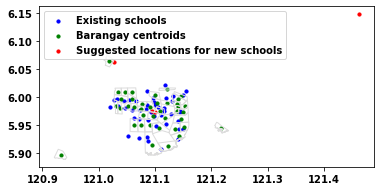

Cluster centers:
                    geometry
0  POINT (121.21667 5.94529)
1  POINT (121.04044 5.98603)
2  POINT (121.44017 6.13827)
3  POINT (120.81059 5.96574)
Inertia: -0.078324
Silhouette score: 0.374556


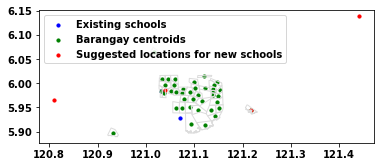

Cluster centers:
                    geometry
0  POINT (121.04779 5.98630)
1  POINT (121.27873 6.04969)
2  POINT (121.11321 5.98800)
3  POINT (120.93214 5.89742)
Inertia: -0.006950
Silhouette score: 0.420957


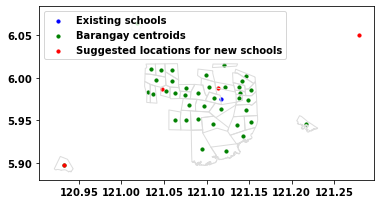

Cluster centers:
                    geometry
0  POINT (121.03013 6.03453)
1  POINT (121.20420 6.02640)
2  POINT (121.01783 6.06375)
3  POINT (120.54684 6.06766)
Inertia: -0.097080
Silhouette score: 0.339006


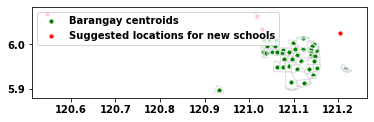

In [44]:
# Municipality & data
muni = 'PH156613000'
data = brgy_df[brgy_df['PSGC_MUNI']==muni]

# Features
feat1 = ['num_elem_to_elem_age_pop', 'elem_age_pop', 'closest_ES_distance']
feat2 = ['num_jhs_to_jhs_age_pop', 'jhs_age_pop', 'closest_JHS_distance']
feat3 = ['num_shs_to_shs_age_pop', 'shs_age_pop', 'closest_SHS_distance']
feat4 = ['num_suc_to_suc_age_pop', 'suc_age_pop', 'closest_SUC_distance']

# Categories of school locations to show
cat1 = ['CES', 'ES', 'PES', 'PS']
cat2 = ['JHS', 'PJHS']
cat3 = ['SHS', 'PSHS']
cat4 = ['SUC']

visualize_results(data, feat1, muni, cat1, 4)
visualize_results(data, feat2, muni, cat2, 4)
visualize_results(data, feat3, muni, cat3, 4)
visualize_results(data, feat4, muni, cat4, 4)